## Sentiment Analysis on 2020 US presidential Election Candidates using Twitter Data.
**Data Information**: Tweets from 1 Republican Party candidate(Donald Trump) and 3 Democrat Party candidates(Joe Biden, Elizabeth Warren, Bernie Sanders) <br>
**Question**: Which Candidate is more negative on which topic? <br>
**Method**: Word Embedding Model(FastText), LSTM-CNN model (RCNN) 

### Required Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import time
start_time = time.time()
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pandas as pd

Using TensorFlow backend.


### Data Preview
There are 4 dataset: Trump, and 3 Democrat party Candidates, Joe Biden, Elizabeth Warren and Bernie Sanders <br>
I collected their tweets from '2019-01-01' to '2019-11-12'. <br>
I merged individual csv files into one df_tweet file (df_politics), just to make sure every dataset is perfectly arranged

In [2]:
tweets = "../input"
embedding_path = "../input/crawl-300d-2M.vec"  #where word2vector model is 

df_Trump = pd.read_csv(os.path.join(tweets,"DonaldTrump.csv"))
df_Bernie = pd.read_csv(os.path.join(tweets, "BernieSanders.csv"))
df_Joe = pd.read_csv(os.path.join(tweets, "JoeBiden.csv"))
df_Elizabeth = pd.read_csv(os.path.join(tweets, "ElizabethWarren.csv"))
df_politics = pd.concat((df_Trump, df_Bernie, df_Joe, df_Elizabeth), axis=0)
df_politics.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2019-11-12 15:41:35,realDonaldTrump,GOPoversight,14480,18330,57563,A total Impeachment Scam by the Do Nothing Dem...,NaN,NaN,NaN,1194279077546483714,https://twitter.com/realDonaldTrump/status/119...
1,2019-11-12 11:45:28,realDonaldTrump,NaN,33449,18779,70176,"Many of the people in DACA, no longer very you...",NaN,NaN,NaN,1194219655717642240,https://twitter.com/realDonaldTrump/status/119...
2,2019-11-12 11:32:57,realDonaldTrump,NaN,11635,19350,97540,Economy is BOOMING. Seems set to have yet anot...,NaN,NaN,NaN,1194216506403545088,https://twitter.com/realDonaldTrump/status/119...
3,2019-11-12 11:31:21,realDonaldTrump,NaN,17679,19238,83973,I will be releasing the transcript of the firs...,NaN,NaN,NaN,1194216106300444672,https://twitter.com/realDonaldTrump/status/119...
4,2019-11-12 11:25:15,realDonaldTrump,NaN,4982,11558,44431,"....Ukrainian energy company, and more million...",NaN,NaN,NaN,1194214569591394304,https://twitter.com/realDonaldTrump/status/119...


### Number of the data
There are total of 11762 tweets. This might seem like a lot of data, but actually relatively small data compared to those which is used in other machine learning projects. <br>




*   Donald Trump: 3929 tweets
*   Elizabeth Warren: 3645 tweets 
*   Bernie Sanders: 2681 tweets <br>
* Joe Biden: 1507 tweets <br>








In [3]:
df_politics.shape

(11762, 12)

### Tokenizer


1.   Separe full text into list of words. For example,

> 'I love you' => ['I', 'love', 'you']

2.   Transform list of words into list of numbers. For example,

>['I', 'love', 'you'] => [16, 322, 22]

3. Make each list of numbers into vectorized value. For example,
```
array([[    0,     0,     0, ...,    30, 10547,    14],
       [    0,     0,     0, ...,    97,     2,   759],
       [    0,     0,     0, ...,   329,   488,   120],
       ...,
       [    0,     0,     0, ...,    11,     7, 25414],
       [    0,     0,     0, ...,    11,     7, 25415],
       [    0,     0,     0, ...,    11,     7, 25419]], dtype=int32)
```



In [4]:
embed_size = 300
max_features = 130000
max_len = 220

df_politics["text"].fillna("no comment")   #if there is any "None" text in data, delete the entire row
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]   #Negative feeling lists
raw_text = df_politics["text"].str.lower()   

tk = Tokenizer(num_words = max_features, lower = True)  #Implement tokenizer model (it helps to divide the text into list of several words. For example, [I love apple] -> ['I', 'love', 'apple'])
tk.fit_on_texts(raw_text)  # Tokenize tweets 
df_politics["comment_seq"] = tk.texts_to_sequences(raw_text)   #Then make them into a number. For example, "I love apple " -> [[16, 322, 2271]]. Insert the printed number into the 'df_politics' table

tweets_pad_sequences = pad_sequences(df_politics.comment_seq, maxlen = max_len) #each row of the table has different length of "comment_seq". Make them into equal length of vector. 
print("The vectorized tweet's shape is: ", tweets_pad_sequences.shape) # Each text has transformed into list of numbers which has length of 84. 

df_politics[['text', 'comment_seq']]

The vectorized tweet's shape is:  (11762, 220)


,text,comment_seq
0,A total Impeachment Scam by the Do Nothing Dem...,"[4, 589, 395, 989, 38, 1, 54, 218, 116, 15, 11..."
1,"Many of the people in DACA, no longer very you...","[119, 5, 1, 29, 6, 1180, 42, 714, 94, 431, 18,..."
2,Economy is BOOMING. Seems set to have yet anot...,"[151, 10, 3150, 1852, 1036, 2, 24, 636, 329, 4..."
3,I will be releasing the transcript of the firs...,"[16, 23, 25, 2235, 1, 1093, 5, 1, 149, 3, 2778..."
4,"....Ukrainian energy company, and more million...","[1251, 384, 706, 3, 47, 230, 901, 45, 241, 3, ..."
...,...,...
3640,Tonight I’m talking to Rachel @Maddow at 9 PM ...,"[364, 83, 548, 2, 3226, 2731, 33, 679, 1046, 1..."
3641,"Last night, I joined some of our best voluntee...","[170, 414, 16, 1351, 286, 5, 12, 297, 3118, 24..."
3642,"I was tickled pink to talk to you too, Cindy! ...","[16, 44, 10483, 25413, 2, 337, 2, 22, 188, 559..."
3643,"I called Melinda yesterday, a preschool teache...","[16, 514, 10178, 516, 4, 7014, 811, 39, 902, 2..."


### Embedding Words into Vector space
Now I need to construct an embedding index, that puts each one of the words into a 300-dimensional vector space.<br>
I used 'FastText' model which was developed from Facebook in 2017. <br>
This is a very revolutionary model, far better than 'GLOVE' or 'Word2Vec'. It calculates the distance between each words in its semantics, and can be redistributed even though there is a new word.


In [5]:
# def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding ="utf-8"))   #This code is to open embedding "Glove model"

In [6]:
# word_list = tk.word_index
# n_words = min(max_features, len(word_list))
# print("number of used words: {}".format(len(word_list)))  #Number of the whole words used in tweet data 
# embedding_matrix = np.zeros((n_words+1, embed_size)) 
# for word, i in word_list.items():
#     if i >= max_features: continue
#     embedding_vector = embedding_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

# embedding_matrix[0].shape

### Machine Learning Model
I have pre-trained model, so I loaded actual trained model and make the predictions on our data.

In [7]:
model = load_model("../input/best_model.hdf5")

It shows how the model actually looks like. This model is mixture of 'LSTM' and 'CNN' model. 

In [8]:
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 220, 300)     39000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 220, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 220, 224)     277536      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

Let's train our web-crawled tweets using 'LSTM-CNN' model.

In [9]:
pred = model.predict(tweets_pad_sequences, batch_size = 1024, verbose = 1)

11762/11762 [==============================] - 8s 638us/step


In [10]:
pred.max()

0.99750805

WOW! This model has 99.75% accuracy! I really didn't expect that. <br>
This means this model can almost 100% distinguish toxic words from the tweets. <br>
Then let's see the summary of this distinguishment

In [11]:
toxic_predictions = pd.DataFrame(columns=list_classes, data=pred)
toxic_predictions['id'] = df_politics['date'].values
toxic_predictions['text'] = df_politics['text'].values
toxic_predictions.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id,text
0,0.760089,0.001366,0.120749,0.000129,0.529312,0.001124,2019-11-12 15:41:35,A total Impeachment Scam by the Do Nothing Dem...
1,0.002788,0.000066,0.000404,0.000012,0.000868,0.000045,2019-11-12 11:45:28,"Many of the people in DACA, no longer very you..."
2,0.009998,0.000174,0.000787,0.000020,0.002682,0.000202,2019-11-12 11:32:57,Economy is BOOMING. Seems set to have yet anot...
3,0.052497,0.000186,0.003516,0.000056,0.010265,0.001874,2019-11-12 11:31:21,I will be releasing the transcript of the firs...
4,0.596469,0.000966,0.137789,0.000076,0.515911,0.033893,2019-11-12 11:25:15,"....Ukrainian energy company, and more million..."


In [12]:
toxic_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,11762.000000,11762.000000,11762.000000,1.176200e+04,11762.000000,11762.000000
mean,0.100985,0.000955,0.065875,1.359792e-04,0.042290,0.007932
std,0.222546,0.005529,0.181956,1.293976e-03,0.116587,0.044407
min,0.000041,0.000002,0.000014,4.172325e-07,0.000037,0.000004
25%,0.000915,0.000027,0.000161,6.437302e-06,0.000405,0.000062
50%,0.002954,0.000059,0.000385,1.609325e-05,0.001077,0.000188
75%,0.039558,0.000211,0.003599,5.170703e-05,0.010978,0.000949
max,0.997508,0.273178,0.992440,7.682255e-02,0.909950,0.823342


In [13]:
toxic_predictions['username'] = df_politics['username'].values
toxic_predictions['text'] = df_politics['text'].values
toxic_predictions.tail()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id,text,username
11757,0.002699,0.000113,0.000551,0.000045,0.000765,0.000366,2019-01-02 22:30:53,Tonight I’m talking to Rachel @Maddow at 9 PM ...,ewarren
11758,0.289937,0.000269,0.013951,0.000040,0.087938,0.000311,2019-01-02 14:42:10,"Last night, I joined some of our best voluntee...",ewarren
11759,0.003570,0.000153,0.000296,0.002624,0.000836,0.000182,2019-01-02 02:36:47,"I was tickled pink to talk to you too, Cindy! ...",ewarren
11760,0.029065,0.000230,0.002965,0.000042,0.005568,0.000252,2019-01-01 18:55:08,"I called Melinda yesterday, a preschool teache...",ewarren
11761,0.000681,0.000028,0.000164,0.000005,0.000263,0.000277,2019-01-01 01:22:47,Bruce & I do the same thing every New Year's E...,ewarren


### Let's check which tweet showed the greatest negative feeling(toxic, insult, identity_hate)
Interesting! It seems relatively correct 

In [14]:
for neg_word in ['toxic', 'insult', 'identity_hate']:
  pd.set_option('display.max_colwidth', -1)
  temp = toxic_predictions[toxic_predictions[neg_word] == max(toxic_predictions[neg_word])]
  print('The most {} text: {}'.format(neg_word, temp['text'].values))
  print(temp['username'])

The most toxic text: ['It is not Congress that regulates the pharmaceutical industry. It is the pharmaceutical industry that regulates Congress.']
4523    BernieSanders
Name: username, dtype: object
The most insult text: ['THE GREATEST SCAM IN THE HISTORY OF AMERICAN POLITICS!']
870    realDonaldTrump
Name: username, dtype: object
The most identity_hate text: ['The Trump Administration continues to attack the progress the LGBTQ community has made. As president, passing the Equality Act will be a top legislative priority, because no one should be fired simply because of who they are or whom they love.https://www.buzzfeednews.com/article/dominicholden/trump-scotus-gay-workers …']
7297    JoeBiden
Name: username, dtype: object


### Compare Politicians' negative Feelings! 

In [15]:
Trump_predictions = toxic_predictions[toxic_predictions['username'] == 'realDonaldTrump']
Sanders_predictions = toxic_predictions[toxic_predictions['username'] == 'BernieSanders']
Warren_predictions = toxic_predictions[toxic_predictions['username'] == 'ewarren']
Biden_predictions = toxic_predictions[toxic_predictions['username'] == 'JoeBiden']

In [16]:
#Trump Summary
Trump_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,3929.000000,3929.000000,3929.000000,3.929000e+03,3929.000000,3929.000000
mean,0.097546,0.001022,0.061798,1.082682e-04,0.041495,0.005245
std,0.224778,0.005142,0.182634,5.166405e-04,0.119670,0.028633
min,0.000061,0.000003,0.000028,6.258488e-07,0.000052,0.000006
25%,0.001065,0.000033,0.000179,7.361174e-06,0.000455,0.000070
50%,0.003186,0.000071,0.000460,1.922250e-05,0.001177,0.000207
75%,0.028190,0.000211,0.002519,6.148219e-05,0.008262,0.000984
max,0.996482,0.113038,0.969794,1.741824e-02,0.909950,0.622445


In [17]:
#Sanders Summary
Sanders_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,2681.000000,2681.000000,2681.000000,2.681000e+03,2681.000000,2681.000000
mean,0.111841,0.001269,0.078801,1.360377e-04,0.043399,0.008155
std,0.235285,0.008634,0.203897,1.631853e-03,0.116365,0.044603
min,0.000057,0.000002,0.000014,5.066395e-07,0.000045,0.000006
25%,0.000838,0.000027,0.000157,6.794930e-06,0.000383,0.000057
50%,0.002711,0.000054,0.000368,1.573563e-05,0.000995,0.000170
75%,0.051507,0.000214,0.005082,4.407763e-05,0.014030,0.001061
max,0.997508,0.273178,0.992440,7.622758e-02,0.909070,0.775405


In [18]:
#Warren Summary
Warren_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,3645.000000,3645.000000,3645.000000,3.645000e+03,3645.000000,3645.000000
mean,0.089513,0.000663,0.055304,1.736159e-04,0.038044,0.007580
std,0.202018,0.003203,0.155285,1.664826e-03,0.104428,0.044574
min,0.000041,0.000003,0.000016,4.172325e-07,0.000037,0.000004
25%,0.000868,0.000025,0.000158,5.692244e-06,0.000394,0.000060
50%,0.002949,0.000052,0.000350,1.445413e-05,0.001060,0.000179
75%,0.036048,0.000196,0.003295,4.905462e-05,0.010526,0.000799
max,0.993701,0.109008,0.947564,7.682255e-02,0.897562,0.688897


In [19]:
#Biden Summary
Biden_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,1507.000000,1507.000000,1507.000000,1.507000e+03,1507.000000,1507.000000
mean,0.118385,0.000930,0.079075,1.170918e-04,0.052656,0.015390
std,0.238470,0.003446,0.196055,9.636891e-04,0.134754,0.069564
min,0.000074,0.000003,0.000028,4.172325e-07,0.000045,0.000005
25%,0.000790,0.000024,0.000147,5.483627e-06,0.000353,0.000051
50%,0.002844,0.000051,0.000344,1.373887e-05,0.000993,0.000188
75%,0.078358,0.000242,0.011069,4.303455e-05,0.017956,0.001186
max,0.991155,0.054597,0.939804,2.605304e-02,0.889951,0.823342


### Plotting

First, I compared the occurence of each negative feelings. <br>
Polticians showed the greatest feeling of toxic, followed by obscene, and insult.

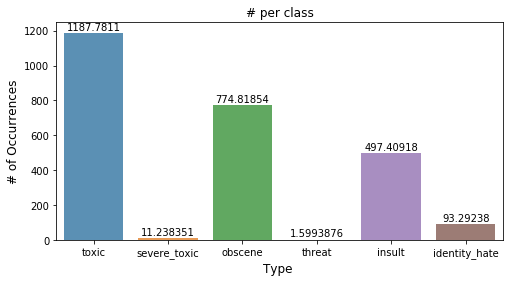

In [20]:
x=toxic_predictions.iloc[:,0:6].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Not all tweets show only one type of feeling. <br>
So, I tried to see what feeling comes frequent with which feeling. 

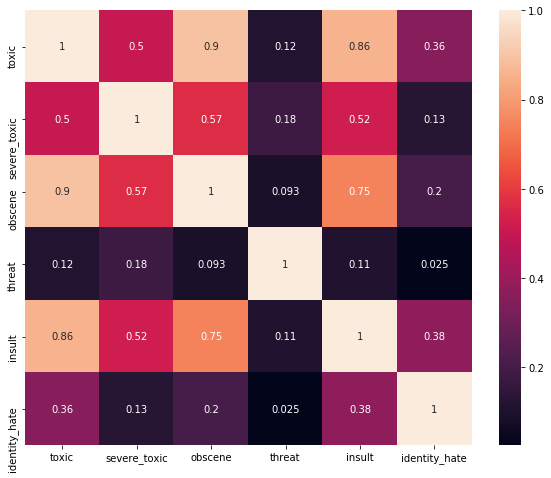

In [21]:
temp_df=toxic_predictions.iloc[:,0:6:]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

### Distribution of each candwidate
very skewed distribution....Unlike what I expected, candidates show realtively low negative feelings in their tweets. <br>
Hmm...Does this prove that candidates use clean words? Or....Is this Facebook's fault? 


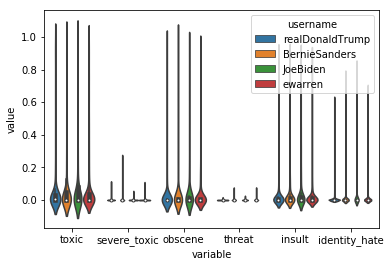

In [22]:
melt_df = pd.melt(toxic_predictions, value_vars=list_classes, id_vars='username')
sns.violinplot(x='variable', y='value', hue='username', data=melt_df)
plt.show()

In [23]:
print("Trump: " + Trump_predictions.loc[Trump_predictions['toxic'].idxmax()]['text'])

Trump: The United States has VERY LOW INFLATION, a beautiful thing!


In [24]:
print(Trump_predictions.sort_values(by=['toxic'], ascending=False)['text'].head(10).values)

['The United States has VERY LOW INFLATION, a beautiful thing!'
 'The United States of America was not involved in the catastrophic accident during final launch preparations for the Safir SLV Launch at Semnan Launch Site One in Iran. I wish Iran best wishes and good luck in determining what happened at Site One.pic.twitter.com/z0iDj2L0Y3'
 'Congratulations to Kelly Knight Craft of #Kentucky on her confirmation as United Nations Ambassador. After having served so admirably as Ambassador to Canada, & having done an outstanding job no matter how difficult the task, Kelly will be fantastic at the United Nations. Winner!'
 '.....on the President of the United States.” @charliekirk11 @trish_regan'
 'H1-B holders in the United States can rest assured that changes are soon coming which will bring both simplicity and certainty to your stay, including a potential path to citizenship. We want to encourage talented and highly skilled people to pursue career options in the U.S.'
 'Sleepy Joe Biden 

In [25]:
print(Sanders_predictions.sort_values(by=['toxic'], ascending=False)['text'].head(10).values)

['It is not Congress that regulates the pharmaceutical industry. It is the pharmaceutical industry that regulates Congress.'
 'We must end the absurdity of the United States having more people in jail than any other country on Earth. We must invest in jobs and education for our young people, not more jails and incarceration.'
 'The insurance industry, the drug industry, the NRA, the fossil fuel industry and the military industrial complex will spend outrageous sums of money to see us fail. I think that says a lot about our campaign. We stand with the people, not those who want to profit off suffering.'
 "In the United States it costs, on average, $12,000 to have a baby. In Finland it costs $60. We've got to end the disgrace of our profit-driven health care system and pass Medicare for all."
 'The fossil fuel industry created the climate crisis. They are going to pay to stop it. #ClimateTownHall'
 'It is a disgrace that the United States locks up more people than any country on Earth. I

In [26]:
print(Warren_predictions.sort_values(by=['toxic'], ascending=False)['text'].head(10).values)

["It's a disgrace to see an Attorney General acting as if he's the personal attorney and publicist for the President of the United States."
 'We must stand united with Tribal Nations and indigenous peoples to ensure that Native voices are heard and their rights are respected. With real structural change, we can write a new story.https://www.nbcnews.com/politics/meet-the-press/live-blog/meet-press-blog-latest-news-analysis-data-driving-political-discussion-n988541/ncrd1043076#liveBlogHeader …'
 'I’m running for president of the United States—and yeah, I’ve got a lot of plans. Thank you, @EssenceFest!https://twitter.com/Essence/status/1147610388604882949 …'
 'This is a disgrace. The American people deserve answers—and Special Counsel Robert Mueller should testify publicly before Congress. #ReleaseTheFullReportpic.twitter.com/ROG0Bt6JVq'
 "Industrial pollution has been disproportionately concentrated in low-income communities and communities of color like in Louisiana's Cancer Alley. We n

In [27]:
print(Biden_predictions.sort_values(by=['toxic'], ascending=False)['text'].head(10).values)

['The clean energy economy of the future presents an enormous opportunity. President Biden will create 10 million well-paying jobs in the United States that will grow a stronger, more inclusive middle class in communities across the country. #ClimateTownHall'
 'We’re going to make record-breaking investments in research and development and zero-carbon technologies so that America is the engine of the world’s clean economy. The United States will be a 100% clean-energy economy with net-zero emissions by 2050. https://go.joebiden.com/Clean-Energy-Revolution-Social …pic.twitter.com/ypw4o7rozG'
 'Folks, earlier today I announced that I’m running for President of the United States. The strength of this movement depends on you. Head over to http://www.joebiden.com/donate to make a donation today. #Joe2020'
 'This initiative will create new, good-paying jobs all across the clean economy in the United States of America. It’s an enormous opportunity. https://go.joebiden.com/clean-energy-jobs …p

### How many times did the candidates mention others?

In [28]:
import re
total = []
num = 0
candidates = ['Trump', 'Sanders','Biden','Warren']
for df_candidate in [df_Trump, df_Bernie, df_Joe, df_Elizabeth]:
    cd_list = [candidates[num]]
    for candidate in candidates:
        count = 0
        for i in df_candidate['text'].values:
            if re.search(candidate, i):
                temp = len(re.findall(candidate, i))
                count+=temp
        cd_list.append(count)
    total.append(cd_list)
    num+=1


In [29]:
header = ['','Trump', 'Sanders','Biden','Warren'] 
pd.DataFrame(total, columns=header, index= None)

,,Trump,Sanders,Biden,Warren
0,Trump,409,12,55,7
1,Sanders,490,66,14,1
2,Biden,405,6,272,2
3,Warren,361,4,0,334
